In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import matplotlib.pyplot as plt
import numpy as np
import nltk
import pandas as pd
import plotly.express as px
import seaborn as sns
import os
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


# 1. Постановка задачи


**> Представьте, что вы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.**

> #  Признаки:

* hotel_address — адрес отеля;
* review_date — дата, когда рецензент разместил соответствующий отзыв;
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля;
* reviewer_nationality — страна рецензента;
* negative_review — отрицательный отзыв, который рецензент дал отелю;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
* positive_review — положительный отзыв, который рецензент дал отелю;
* review_total_positive_word_counts — общее количество слов в положительном отзыве.
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* tags — теги, которые рецензент дал отелю;
* days_since_review — количество дней между датой проверки и датой очистки;
* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat — географическая широта отеля;
* lng — географическая долгота отеля.

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Подгрузим наши данные из соревнования

#DATA_DIR = '/kaggle/input/sf-booking/'
DATA_DIR = ''
df_train = pd.read_csv(DATA_DIR + '/kaggle/input/sf-booking/hotels_train.csv')
df_test = pd.read_csv(DATA_DIR + '/kaggle/input/sf-booking/hotels_test.csv')
sample_submission = pd.read_csv(DATA_DIR + '/kaggle/input/sf-booking/submission.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
df_test.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520


In [9]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [10]:
sample_submission.head(3)

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688


**Для обработки признаков соединим тренировочный и тестовый датасет в один, для разделения добавим общий признак sample, который будет равен 1 для тренировочных данных и 0 для тестовых. Так же в тестовом датасете создадим целевой признак reviewer_score и заполним его нулями.**

In [11]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

/tmp/ipykernel_20/154621427.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [13]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [14]:
fig1_data = df_train['reviewer_score']
fig01 = px.box(
    fig1_data,
    x='reviewer_score',
    #color='Exited',
    height=400, width=1000,
    title='Распределение оценок гостей'
    )
fig01.show()

fig02 = px.histogram(
    df_train,
    x='reviewer_score',
    histfunc='count',
    nbins=17,
    range_x=[0,10],
    height=400, width=1000,
    title='Распределение оценок гостей'
    )
fig02.show()

#  2. Проектирование признаков

In [15]:
# Список для удаления признаков
drop_list = list()

drop_list.append('hotel_address')

In [16]:
# Создадим новый признак страны отеля
data['hotel_country'] = data['hotel_address'].apply(lambda x: x.split()[-1])
data.loc[data['hotel_country'] == 'Kingdom','hotel_country'] = 'United Kingdom'
data['hotel_country'].value_counts()

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: hotel_country, dtype: int64

In [17]:
# Создадим новый признак города отеля
data['hotel_city'] = data['hotel_address'].apply(lambda x: x.split()[-5] if x.split()[-1] == 'Kingdom' else x.split()[-2])
data['hotel_city'].value_counts()

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: hotel_city, dtype: int64

In [18]:
# закодируем признаки hotel_country и hotel_city
encoder = ce.OneHotEncoder(cols=['hotel_country']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['hotel_country'])
data = pd.concat([data, type_bin], axis=1)

encoder = ce.OneHotEncoder(cols=['hotel_city']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['hotel_city'])
data = pd.concat([data, type_bin], axis=1)

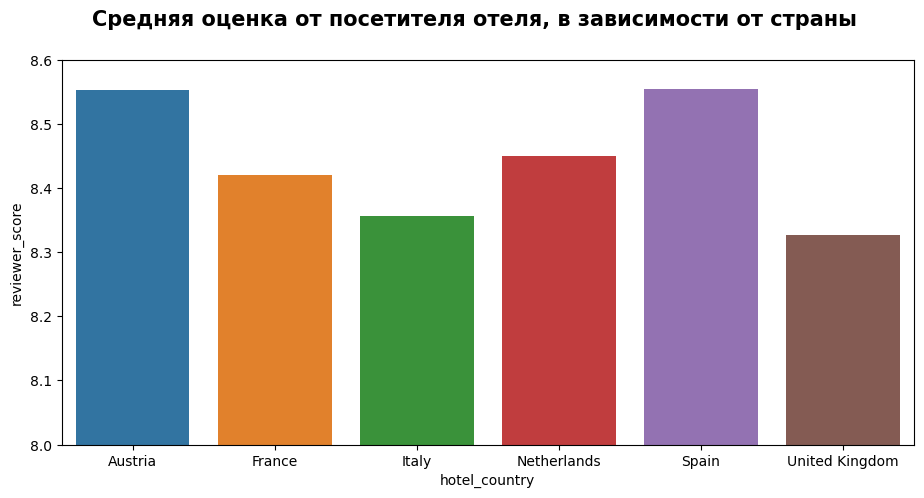

In [19]:
# Возьмем данные целевого признака из train выборки
reviewer_score_country = data[data['sample']==1].pivot_table(
    values='reviewer_score', 
    index='hotel_country', 
    aggfunc='mean')

plt.figure(figsize=(11, 5))
barplot_m = sns.barplot(
    data = reviewer_score_country,
    x = reviewer_score_country.index, 
    y = 'reviewer_score')
plt.suptitle(
    'Средняя оценка от посетителя отеля, в зависимости от страны', 
    fontweight='bold', 
    fontsize=15)

# Ограничим диапазон оценки для большей наглядности
plt.ylim(8, 8.6);


In [20]:
drop_list.append('hotel_country')

In [21]:
drop_list.append('hotel_city')

**Признак - review_date**

In [22]:
# Создаим новые признаки дат: год, месяц, день
data['review_date']=pd.to_datetime(data['review_date'])
data['month']=pd.to_datetime(data['review_date']).dt.month
data['year']=pd.to_datetime(data['review_date']).dt.year
data['day']=pd.to_datetime(data['review_date']).dt.day

In [23]:
# Закодируем признак reviewer_nationality
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)
data.drop(['reviewer_nationality'],axis=1,inplace=True)

In [24]:
drop_list.append('review_date')

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   negative_review                             515738 non-null  object        
 6   review_total_negative_word_counts           515738 non-null  int64         
 7   total_number_of_reviews                     515738 non-null  int64         
 8   positive_review                             515738 non-null  object       

In [26]:
data['reviewer_nationality_7']

0         1
1         0
2         1
3         0
4         1
         ..
515733    1
515734    0
515735    0
515736    0
515737    0
Name: reviewer_nationality_7, Length: 515738, dtype: int64

**Признак - tags**

In [27]:
data['tags']

0         [' Leisure trip ', ' Couple ', ' Double Room '...
1         [' Leisure trip ', ' Group ', ' Triple Room ',...
2         [' Business trip ', ' Solo traveler ', ' Twin ...
3         [' Leisure trip ', ' Couple ', ' Ambassador Ju...
4         [' Business trip ', ' Solo traveler ', ' Class...
                                ...                        
515733    [' Leisure trip ', ' Group ', ' Club Double or...
515734    [' Leisure trip ', ' Couple ', ' Standard Doub...
515735    [' Business trip ', ' Solo traveler ', ' Singl...
515736    [' Leisure trip ', ' Solo traveler ', ' Deluxe...
515737    [' Leisure trip ', ' Couple ', ' Bunk Bed Room...
Name: tags, Length: 515738, dtype: object

In [28]:
def re_func(num_tags):
    num_tags = num_tags[2:-2]
    res = num_tags.strip().split(' \', \' ')
    return res

data['tags'] = data['tags'].apply(re_func)

In [29]:
data_copy = data.explode('tags')
tags_counts = data_copy['tags'].value_counts()[:20]
data_tags_counts = pd.DataFrame(tags_counts).reset_index()
data_tags_counts.columns = ['unique_tags', 'counts_unique_tags']
top_tags = set(data_tags_counts['unique_tags'])

In [30]:
# Используем эти 20 тегов что бы создать в нашем датасете 20 новых признаков
# 1 -  в отзыве есть этот тег, 0 - тега нет

for tag in top_tags:
    tag_name = str(tag)
    data[tag_name] =  data['tags'].apply(lambda x: 1 if tag_name in x else 0)

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 62 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   negative_review                             515738 non-null  object        
 6   review_total_negative_word_counts           515738 non-null  int64         
 7   total_number_of_reviews                     515738 non-null  int64         
 8   positive_review                             515738 non-null  object       

**Отзывы**

In [32]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Первым делом подправим явные выражения 
data['negative_review'] = data['negative_review'].apply(lambda x: x.replace('No Negative', 'Positive'))
data['negative_review'] = data['negative_review'].apply(lambda x: x.replace('N A', 'Positive'))
data['negative_review'] = data['negative_review'].apply(
    lambda x: x.replace('All good', 'Positive'))
data['negative_review'] = data['negative_review'].apply(
    lambda x: x.replace('No complaints', 'Positive'))
data['negative_review'] = data['negative_review'].apply(
    lambda x: x.replace('Nothing to dislike', 'Positive'))
data['positive_review'] = data['positive_review'].apply(
    lambda x: x.replace('No Positive', 'Negative'))

# создаем два экземпляра анализатора, чтобы разделить лексикон 
# для разной системы оценки положительных и отрицательных отзывов:
sia_neg = SentimentIntensityAnalyzer()
sia_pos = SentimentIntensityAnalyzer()

data['neg_scores'] = data['negative_review'].apply(lambda x: sia_neg.polarity_scores(x))
data['pos_scores'] = data['positive_review'].apply(lambda x: sia_pos.polarity_scores(x))

# формируем новые признаки:
data['n_review_sentiments_neg'] = data['neg_scores'].apply(lambda x: x['neg'])
data['n_review_sentiments_neu'] = data['neg_scores'].apply(lambda x: x['neu'])
data['n_review_sentiments_pos'] = data['neg_scores'].apply(lambda x: x['pos'])
data['n_review_sentiments_compound'] = data['neg_scores'].apply(lambda x: x['compound'])

data['p_review_sentiments_neg'] = data['pos_scores'].apply(lambda x: x['neg'])
data['p_review_sentiments_neu'] = data['pos_scores'].apply(lambda x: x['neu'])
data['p_review_sentiments_pos'] = data['pos_scores'].apply(lambda x: x['pos'])
data['p_review_sentiments_compound'] = data['pos_scores'].apply(lambda x: x['compound'])

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 72 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   negative_review                             515738 non-null  object        
 6   review_total_negative_word_counts           515738 non-null  int64         
 7   total_number_of_reviews                     515738 non-null  int64         
 8   positive_review                             515738 non-null  object       

# 3. Кодирование и отбор признаков

**Аналих мультиколлинеарности**

/tmp/ipykernel_20/3378021215.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Наиболее высокая корреляция между признаками:


,level_0,level_1,0
1172,hotel_city_4,hotel_country_4,1.000000
986,hotel_city_1,hotel_country_1,1.000000
1048,hotel_city_2,hotel_country_2,1.000000
1110,hotel_city_3,hotel_country_3,1.000000
1234,hotel_city_5,hotel_country_5,1.000000
1296,hotel_city_6,hotel_country_6,1.000000
3409,n_review_sentiments_pos,n_review_sentiments_neu,0.940379
497,sample,reviewer_score,0.931753
2352,Leisure trip,Business trip,0.904034
1104,hotel_city_3,lat,0.845573


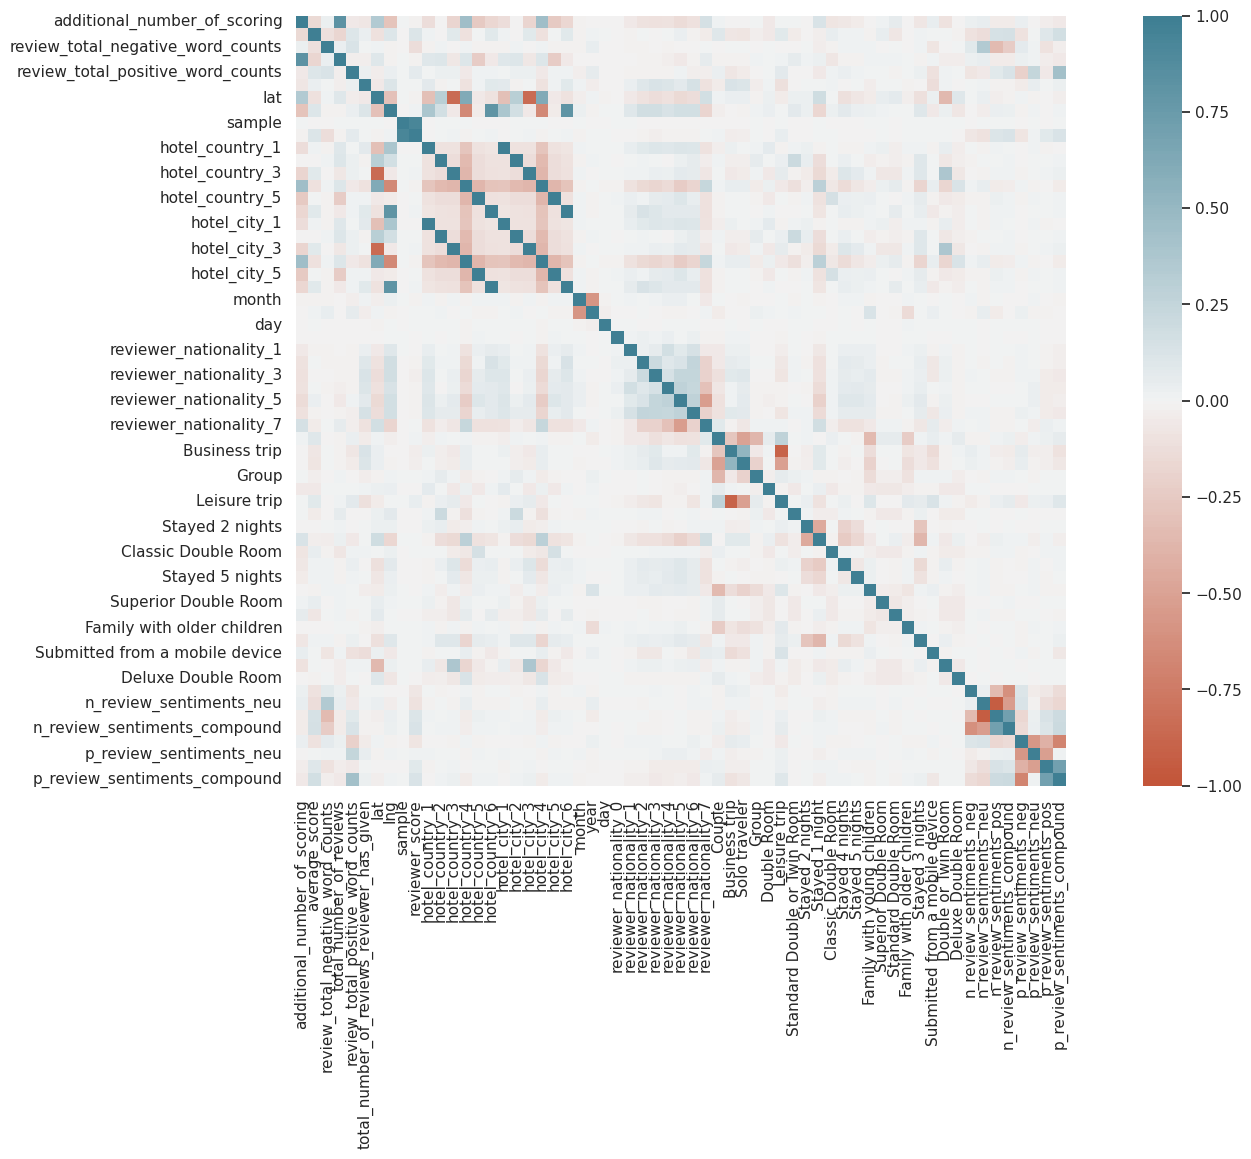

In [34]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
corr = data.corr()
sns.set(rc={'figure.figsize':(20, 10)})
ax = sns.heatmap(
    corr, 
    vmin=-1, 
    vmax=1, 
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
);
print('Наиболее высокая корреляция между признаками:')
corr_unstack = corr.abs().unstack().reset_index()
corr_unstack = corr_unstack.sort_values(by=[0], ascending=False)
mask = corr_unstack['level_0'] != corr_unstack['level_1']
corr_unstack = corr_unstack[mask]
corr_unstack['pr1'] = corr_unstack['level_0'] + corr_unstack['level_1']
corr_unstack['pr1'] = corr_unstack['pr1'].apply(lambda x: ''.join(sorted(list(x))))
corr_unstack = corr_unstack.drop_duplicates(subset=['pr1'])
corr_unstack = corr_unstack.drop(['pr1'], axis=1)
corr_unstack.iloc[:20, :]

In [35]:
#Удалим признаки с корреляцией больше 0.75
drop_list.append('neg_scores')
drop_list.append('pos_scores')
drop_list.append('tags')
drop_list.append('hotel_name')
drop_list.append('negative_review')
drop_list.append('positive_review')
drop_list.append('positive_review')
drop_list.append('days_since_review')

In [36]:
#удаляем признаки которые задавали в список для удаления drop_list
data.drop(drop_list, axis = 1, inplace=True)

In [37]:
data = data.fillna(0)

 # 4. Создание и обучение модели

In [38]:
# Делим объединённый датасет на тренировочную тестовую часть, а тренировочную на признаки и таргет
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'reviewer_score'], axis=1)

y = train_data.reviewer_score.values
X = train_data.drop(['reviewer_score'], axis=1)

In [39]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [40]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 59), (386803, 60), (386803, 59), (309442, 59), (77361, 59))

In [41]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [42]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [43]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.4s finished


In [44]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE/MAPE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAE: 0.8777950166535244
MAPE: 0.1252688528770007


<Axes: >

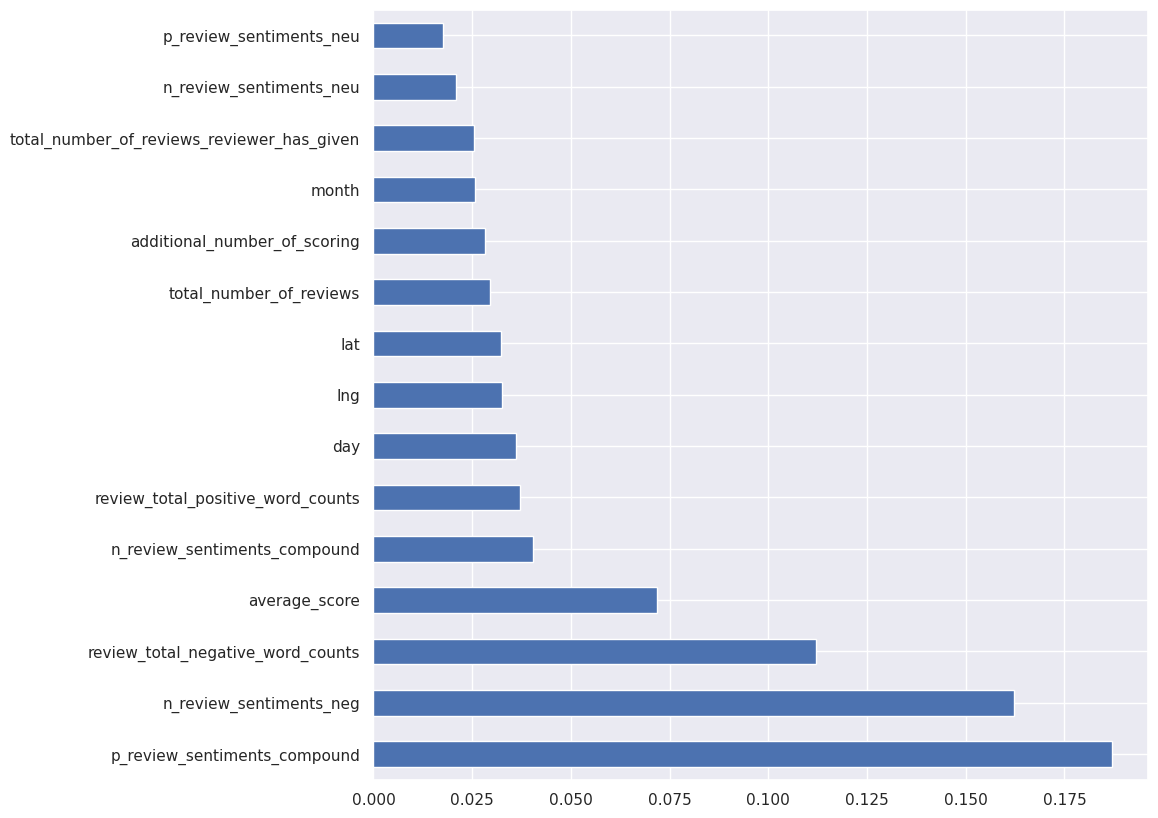

In [45]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [46]:
test_data.columns

Index(['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'lat', 'lng',
       'hotel_country_1', 'hotel_country_2', 'hotel_country_3',
       'hotel_country_4', 'hotel_country_5', 'hotel_country_6', 'hotel_city_1',
       'hotel_city_2', 'hotel_city_3', 'hotel_city_4', 'hotel_city_5',
       'hotel_city_6', 'month', 'year', 'day', 'reviewer_nationality_0',
       'reviewer_nationality_1', 'reviewer_nationality_2',
       'reviewer_nationality_3', 'reviewer_nationality_4',
       'reviewer_nationality_5', 'reviewer_nationality_6',
       'reviewer_nationality_7', 'Couple', 'Business trip', 'Solo traveler',
       'Group', 'Double Room', 'Leisure trip', 'Standard Double or Twin Room',
       'Stayed 2 nights', 'Stayed 1 night', 'Classic Double Room',
       'Stayed 4 nights', 'Stayed 5 nights', 'Family with young children',

In [47]:
# test_data = test_data.drop(['reviewer_score'], axis=1)

In [48]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [49]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.3s finished


In [50]:
predict_submission

array([8.548, 7.372, 8.56 , ..., 8.326, 9.543, 7.24 ])

In [51]:
list(sample_submission)

['reviewer_score', 'id']

In [52]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.548,488440
1,7.372,274649
2,8.560,374688
3,9.701,404352
4,9.778,451596
5,9.028,302161
6,7.203,317079
7,7.270,13963
8,8.135,159785
9,7.516,195089


**Показатель MAE сосотавляет  0.876, что лучше, чем показатель базового решения.**
**Показатель MAPE сосотавляет  0.125 (12.5%), что лучше, чем показатель базового решения.**